Molecular descriptors¶

Similarity can be assessed in many different ways depending on the application (see J. Med. Chem. (2014), 57, 3186-3204):

    1D molecular descriptor: Solubility, logP, molecular weight, melting point.

        Global descriptor: only one value represents the whole molecule

        Usually do not contain enough information to be applied to machine learning (ML)

        Can be added to 2D fingerprints to improve molecular encoding for ML

    2D molecular descriptors: Molecular graphs, paths, fragments, atom environments

        Detailed representation of individual parts of the molecule

        Contains many features/bits per molecule called fingerprints

        Very often used in similarity search and ML

    3D molecular descriptors: Shape, stereochemistry

        Less robust than 2D representations because of molecule flexibility (what is the “right” conformation of a molecule?) Biological similarity

        Biological fingerprint, e.g. individual bits represent bioactivity measure against different targets

        Independent of molecular structure

        Requires experimental (or predicted) data



In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import (
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys,
    rdFingerprintGenerator,
)

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [3]:
# Molecules in SMILES format
molecule_smiles = [
    "CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O",
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C",
    "C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl",
    "CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC",
    "C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl",
    "CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C",
    "CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O",
    "CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O",
]

# List of molecule names
molecule_names = [
    "Doxycycline",
    "Amoxicilline",
    "Furosemide",
    "Glycol dilaurate",
    "Hydrochlorothiazide",
    "Isotretinoin",
    "Tetracycline",
    "Hemi-cycline D",
]

,smiles,name,ROMol
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,

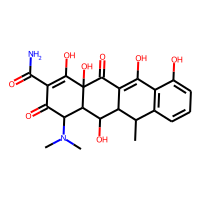
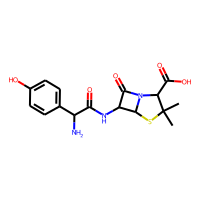

In [4]:
molecules = pd.DataFrame({"smiles": molecule_smiles, "name": molecule_names})
PandasTools.AddMoleculeColumnToFrame(molecules, smilesCol="smiles")
# Show first 2 molecules
molecules.head(2)

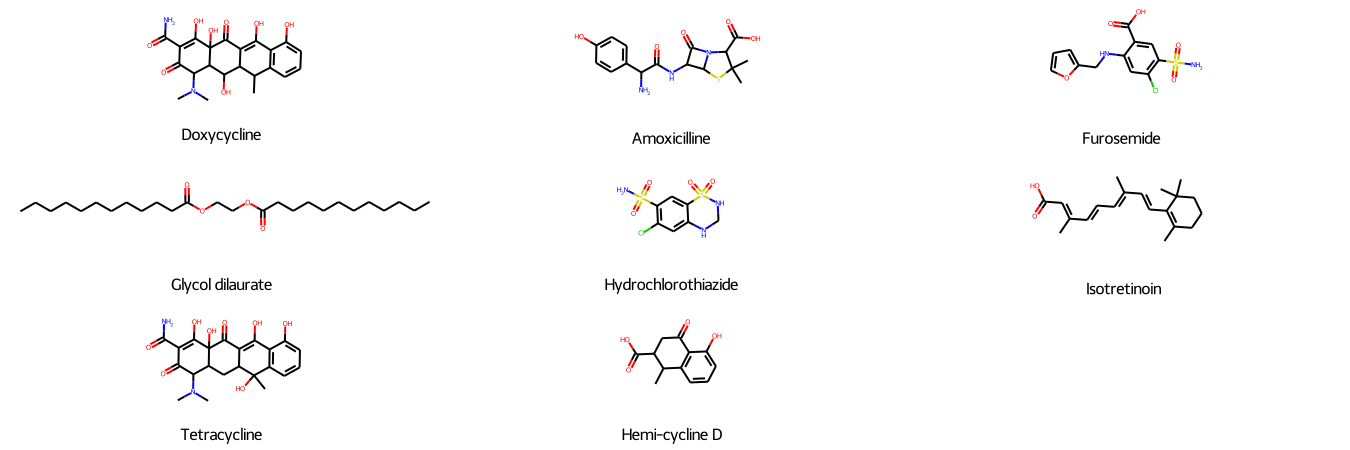

In [5]:
Draw.MolsToGridImage(
    molecules["ROMol"].to_list(),
    molsPerRow=3,
    subImgSize=(450, 150),
    legends=molecules["name"].to_list(),
)

In [6]:
# Note -- we use pandas apply function to apply the MolWt function
# to all ROMol objects in the DataFrame
molecules["molecule_weight"] = molecules.ROMol.apply(Descriptors.MolWt)
# Sort molecules by molecular weight
molecules.sort_values(["molecule_weight"], ascending=False, inplace=True)

In [7]:
# Show only molecule names and molecular weights
molecules[["smiles", "name", "molecule_weight"]]
# NBVAL_CHECK_OUTPUT

,smiles,name,molecule_weight
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,444.440
6,CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Tetracycline,444.440
3,CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC,Glycol dilaurate,426.682
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,365.411
2,C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl,Furosemide,330.749
5,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,Isotretinoin,300.442
4,C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl,Hydrochlorothiazide,297.745
7,CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O,Hemi-cycline D,220.224


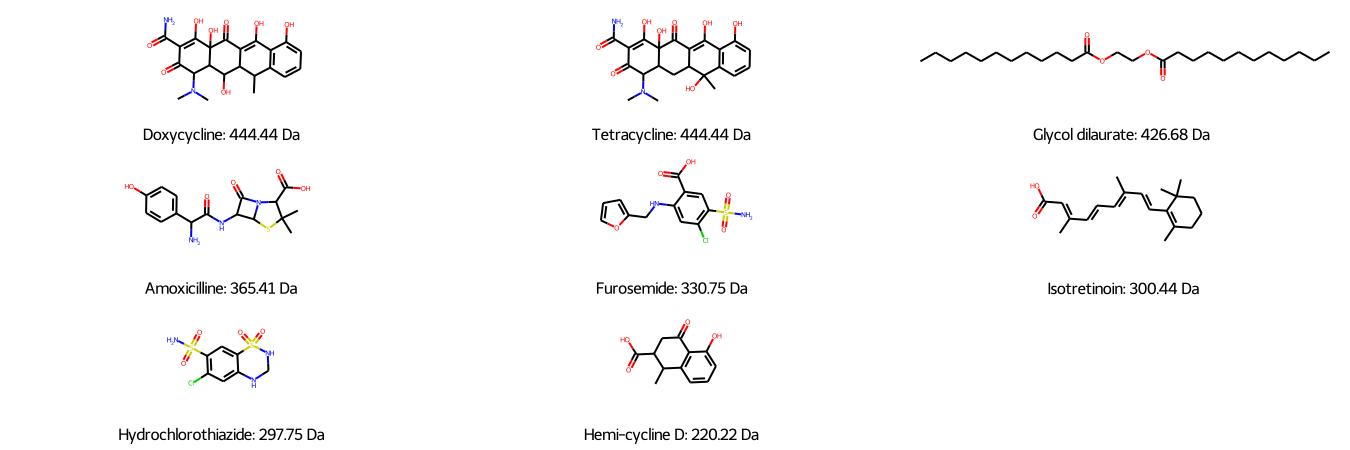

In [8]:
Draw.MolsToGridImage(
    molecules["ROMol"],
    legends=[
        f"{molecule['name']}: {molecule['molecule_weight']:.2f} Da"
        for index, molecule in molecules.iterrows()
    ],
    subImgSize=(450, 150),
    molsPerRow=3,
)

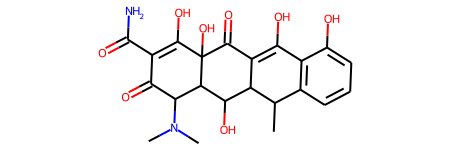

In [9]:
molecule = molecules["ROMol"][0]
molecule

In [10]:
maccs_fp = MACCSkeys.GenMACCSKeys(molecule)

In [11]:
# NBVAL_CHECK_OUTPUT
maccs_fp.ToBitString()

'00000000000000000000000000100000000000000000000000100110000000000010000010101000000011100100110101010100010000101100010000100001000101001001111111101111101011111111110'

In [12]:
molecules["maccs"] = molecules.ROMol.apply(MACCSkeys.GenMACCSKeys)

In [13]:
circular_int_fp = rdFingerprintGenerator.GetCountFPs([molecule])[0]
circular_int_fp

In [14]:
# NBVAL_CHECK_OUTPUT
print(f"Print non-zero elements:\n{circular_int_fp.GetNonzeroElements()}")

Print non-zero elements:
{45: 1, 118: 1, 140: 1, 163: 1, 276: 1, 303: 1, 309: 1, 314: 2, 371: 1, 438: 1, 525: 1, 557: 1, 650: 3, 673: 1, 699: 1, 807: 6, 824: 1, 829: 1, 881: 1, 1009: 1, 1019: 5, 1027: 1, 1039: 1, 1057: 3, 1060: 1, 1061: 1, 1070: 1, 1082: 1, 1088: 1, 1119: 1, 1154: 1, 1163: 2, 1171: 1, 1257: 1, 1296: 1, 1309: 1, 1341: 1, 1380: 9, 1389: 1, 1457: 1, 1471: 1, 1487: 1, 1582: 1, 1602: 3, 1607: 1, 1630: 1, 1747: 1, 1750: 2, 1831: 1, 1833: 1, 1857: 1, 1873: 3, 1917: 1, 1932: 1, 2000: 1, 2029: 1}


In [15]:
# Note that the function takes a list as input parameter
# (even if we only want to pass one molecule)
circular_bit_fp = rdFingerprintGenerator.GetFPs([molecule])[0]
circular_bit_fp

In [16]:
# NBVAL_CHECK_OUTPUT
print(f"Print top 400 fingerprint bits:\n{circular_bit_fp.ToBitString()[:400]}")

Print top 400 fingerprint bits:
0000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000010000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000001000001000010000000000000000000000000000000000000000000000000000000010000000000000000000000000000


In [17]:
molecules["morgan"] = rdFingerprintGenerator.GetFPs(molecules["ROMol"].tolist())

In [18]:
# Example molecules
molecule1 = molecules["ROMol"][0]
molecule2 = molecules["ROMol"][1]

# Example fingerprints
maccs_fp1 = MACCSkeys.GenMACCSKeys(molecule1)
maccs_fp2 = MACCSkeys.GenMACCSKeys(molecule2)

In [19]:
# NBVAL_CHECK_OUTPUT
DataStructs.TanimotoSimilarity(maccs_fp1, maccs_fp2)

0.5909090909090909

In [20]:
# NBVAL_CHECK_OUTPUT
DataStructs.TanimotoSimilarity(maccs_fp1, maccs_fp1)

1.0

In [21]:
# Define molecule query and list
molecule_query = molecules["maccs"][0]
molecule_list = molecules["maccs"].to_list()
# Calculate similarty values between query and list elements
molecules["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_maccs"] = DataStructs.BulkDiceSimilarity(molecule_query, molecule_list)

In [22]:
preview = molecules.sort_values(["tanimoto_maccs"], ascending=False).reset_index()
preview[["name", "tanimoto_maccs", "dice_maccs"]]
# NBVAL_CHECK_OUTPUT

,name,tanimoto_maccs,dice_maccs
0,Doxycycline,1.000000,1.000000
1,Tetracycline,0.928571,0.962963
2,Amoxicilline,0.590909,0.742857
3,Hemi-cycline D,0.403509,0.575000
4,Furosemide,0.321839,0.486957
5,Hydrochlorothiazide,0.306818,0.469565
6,Isotretinoin,0.288136,0.447368
7,Glycol dilaurate,0.149254,0.259740


In [26]:
def draw_ranked_molecules(molecules, sort_by_column):
    """
    Draw molecules sorted by a given column.

    Parameters
    ----------
    molecules : pandas.DataFrame
        Molecules (with "ROMol" and "name" columns and a column to sort by.
    sort_by_column : str
        Name of the column used to sort the molecules by.

    Returns
    -------
    Draw.MolsToGridImage
        2D visualization of sorted molecules.
    """

    molecules_sorted = molecules.sort_values([sort_by_column], ascending=False).reset_index()
    return Draw.MolsToGridImage(
        molecules_sorted["ROMol"],
        legends=[
            f"#{index+1} {molecule['name']}, similarity={molecule[sort_by_column]:.2f}"
            for index, molecule in molecules_sorted.iterrows()
        ],
        molsPerRow=3,
        subImgSize=(450, 150),
    )


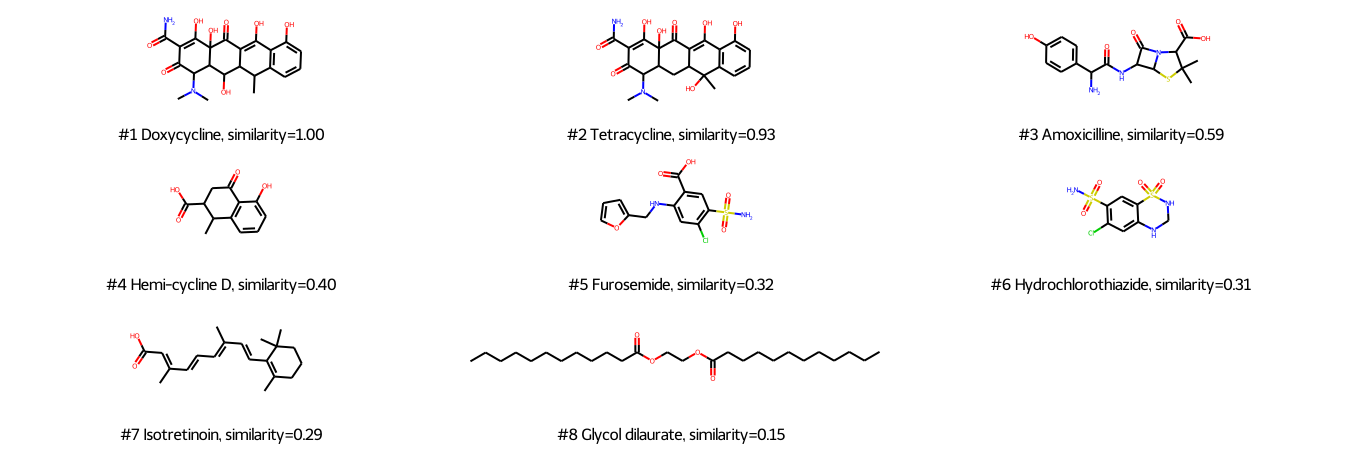

In [27]:
draw_ranked_molecules(molecules, "tanimoto_maccs")

In [33]:
# Define molecule query and list
molecule_query = molecules["morgan"][0]
molecule_list = molecules["morgan"].to_list()
# Calculate similarty values between query and list elements
molecules["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_morgan"] = DataStructs.BulkDiceSimilarity(molecule_query, molecule_list)

In [34]:
preview = molecules.sort_values(["tanimoto_morgan"], ascending=False).reset_index()
preview[["name", "tanimoto_morgan", "dice_morgan", "tanimoto_maccs", "dice_maccs"]]
# NBVAL_CHECK_OUTPUT

,name,tanimoto_morgan,dice_morgan,tanimoto_maccs,dice_maccs
0,Doxycycline,1.000000,1.000000,1.000000,1.000000
1,Tetracycline,0.534247,0.696429,0.928571,0.962963
2,Hemi-cycline D,0.308824,0.471910,0.403509,0.575000
3,Amoxicilline,0.144444,0.252427,0.590909,0.742857
4,Furosemide,0.098901,0.180000,0.321839,0.486957
5,Isotretinoin,0.067416,0.126316,0.288136,0.447368
6,Hydrochlorothiazide,0.058824,0.111111,0.306818,0.469565
7,Glycol dilaurate,0.054795,0.103896,0.149254,0.259740


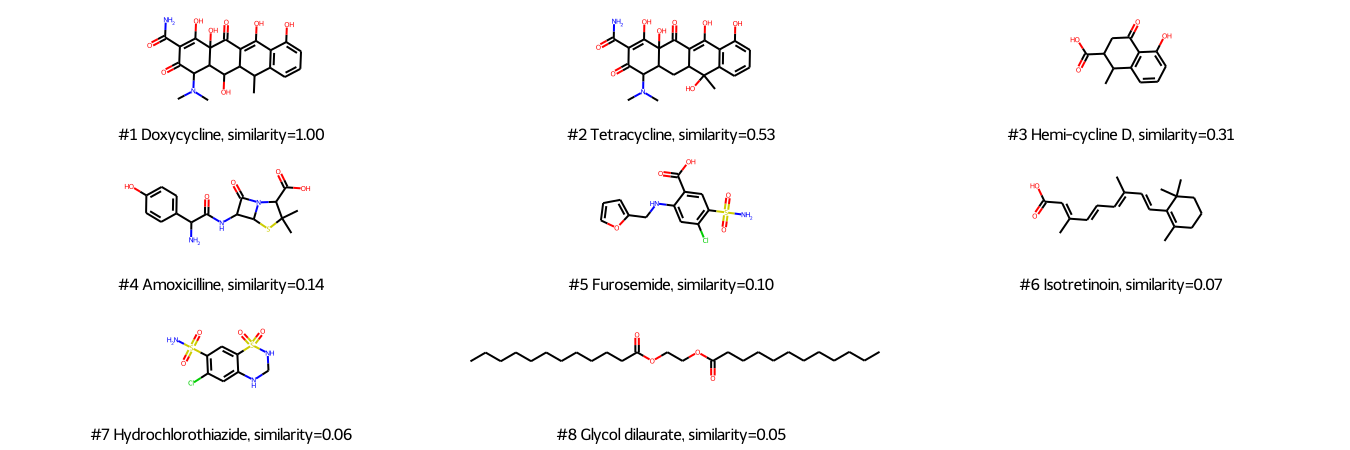

In [35]:
draw_ranked_molecules(molecules, "tanimoto_morgan")

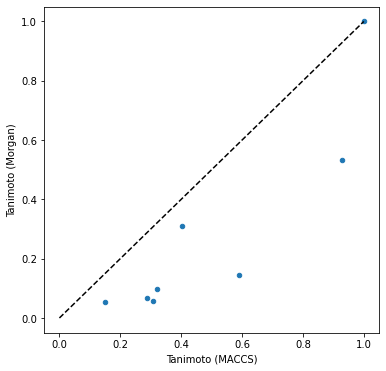

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))
molecules.plot("tanimoto_maccs", "tanimoto_morgan", kind="scatter", ax=ax)
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("Tanimoto (MACCS)")
ax.set_ylabel("Tanimoto (Morgan)")
fig;

In [38]:
molecule_dataset = pd.read_csv(
    HERE / "../T002_ADME_lead_likeness/data/EGFR_compounds_lipinski.csv",
    usecols=["molecule_chembl_id", "smiles", "pIC50"],
)
print(f"Number of molecules in dataset: {len(molecule_dataset)}")
molecule_dataset.head(5)

Number of molecules in dataset: 4525


,molecule_chembl_id,smiles,pIC50
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
4,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910


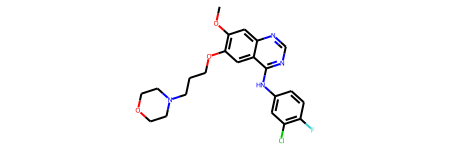

In [39]:
query = Chem.MolFromSmiles("COC1=C(OCCCN2CCOCC2)C=C2C(NC3=CC(Cl)=C(F)C=C3)=NC=NC2=C1")
query

In [40]:
maccs_fp_query = MACCSkeys.GenMACCSKeys(query)
circular_fp_query = rdFingerprintGenerator.GetCountFPs([query])[0]

In [41]:
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles")
circular_fp_list = rdFingerprintGenerator.GetCountFPs(molecule_dataset["ROMol"].tolist())
maccs_fp_list = molecule_dataset["ROMol"].apply(MACCSkeys.GenMACCSKeys).tolist()

In [43]:
molecule_dataset["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(
    maccs_fp_query, maccs_fp_list
)
molecule_dataset["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(
    circular_fp_query, circular_fp_list
)

In [44]:
molecule_dataset["dice_maccs"] = DataStructs.BulkDiceSimilarity(maccs_fp_query, maccs_fp_list)
molecule_dataset["dice_morgan"] = DataStructs.BulkDiceSimilarity(
    circular_fp_query, circular_fp_list
)

In [45]:
# NBVAL_CHECK_OUTPUT
molecule_dataset[
    ["smiles", "tanimoto_maccs", "tanimoto_morgan", "dice_maccs", "dice_morgan"]
].head(5)

,smiles,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,0.409836,0.324786,0.581395,0.490323
1,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,0.666667,0.445455,0.800000,0.616352
2,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,0.484375,0.327434,0.652632,0.493333
3,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,0.428571,0.333333,0.600000,0.500000
4,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,0.384615,0.345133,0.555556,0.513158


,molecule_chembl_id,smiles,pIC50,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,,0.409836,0.324786,0.581395,0.490323
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,,0.666667,0.445455,0.800000,0.616352
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,,0.484375,0.327434,0.652632,0.493333

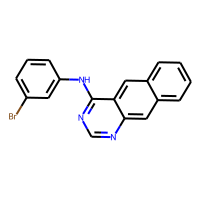
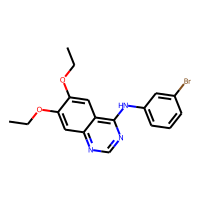
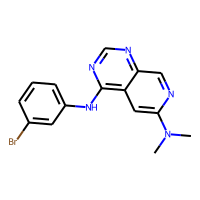

In [46]:
# Show all columns
molecule_dataset.head(3)

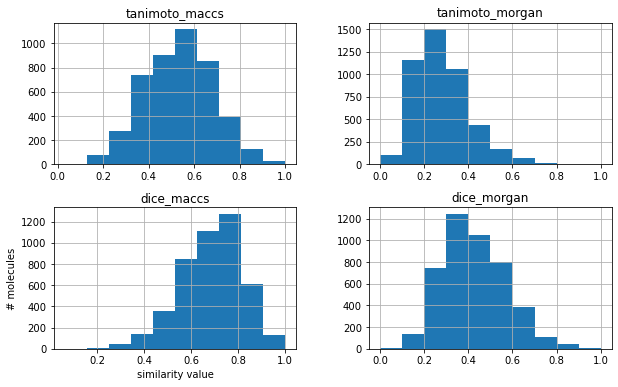

In [47]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
molecule_dataset.hist(["tanimoto_maccs"], ax=axes[0, 0])
molecule_dataset.hist(["tanimoto_morgan"], ax=axes[0, 1])
molecule_dataset.hist(["dice_maccs"], ax=axes[1, 0])
molecule_dataset.hist(["dice_morgan"], ax=axes[1, 1])
axes[1, 0].set_xlabel("similarity value")
axes[1, 0].set_ylabel("# molecules")
fig;

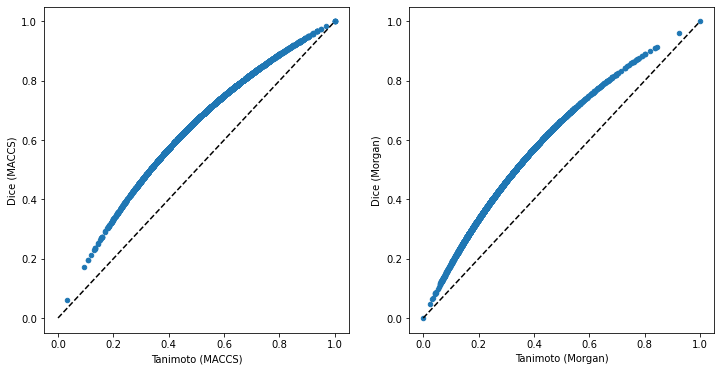

In [48]:
fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

molecule_dataset.plot("tanimoto_maccs", "dice_maccs", kind="scatter", ax=axes[0])
axes[0].plot([0, 1], [0, 1], "k--")
axes[0].set_xlabel("Tanimoto (MACCS)")
axes[0].set_ylabel("Dice (MACCS)")

molecule_dataset.plot("tanimoto_morgan", "dice_morgan", kind="scatter", ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_xlabel("Tanimoto (Morgan)")
axes[1].set_ylabel("Dice (Morgan)")

fig;

,molecule_chembl_id,smiles,pIC50,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
2563,CHEMBL939,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,6.288193,,1.000000,1.000000,1.000000,1.000000
881,CHEMBL14699,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCN1CCOCC1,8.000000,,1.000000,0.923913,1.000000,0.960452
1688,CHEMBL299672,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCCC1,7.148742,,0.919355,0.843750,0.957983,0.915254

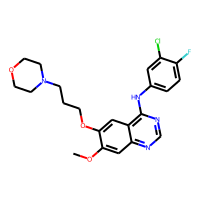
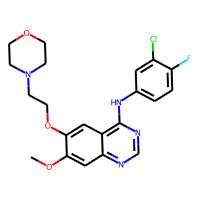
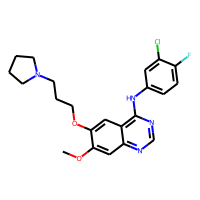

In [49]:
molecule_dataset.sort_values(["tanimoto_morgan"], ascending=False).head(3)

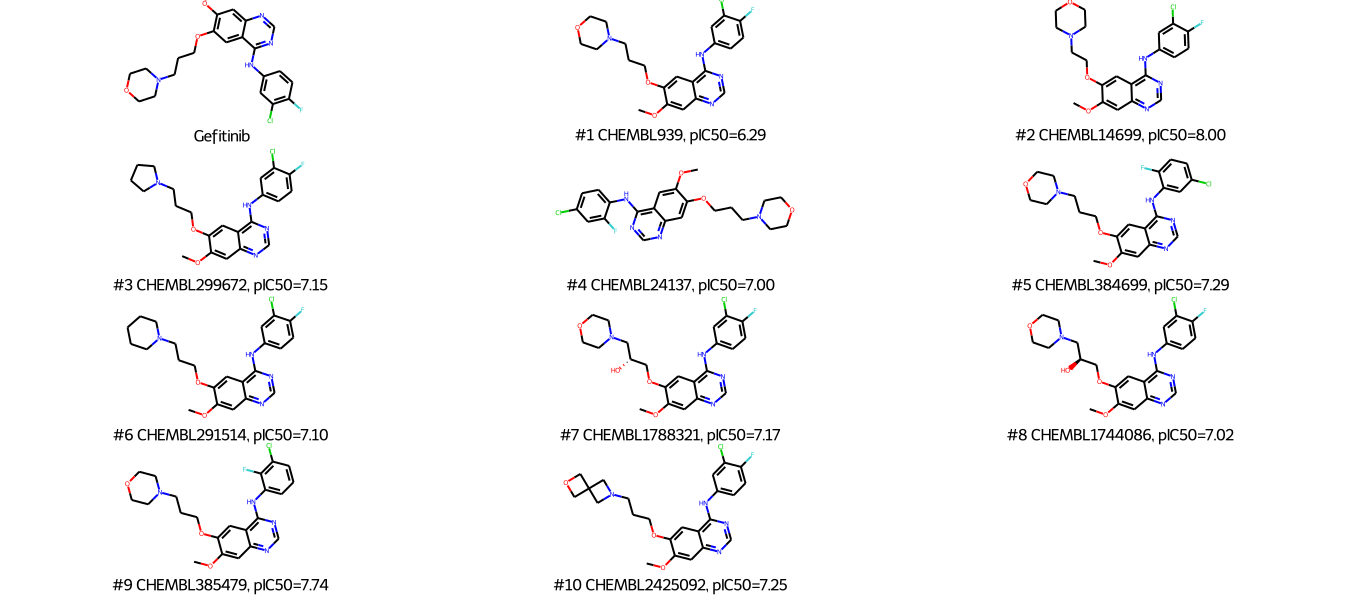

In [50]:
top_n_molecules = 10
top_molecules = molecule_dataset.sort_values(["tanimoto_morgan"], ascending=False).reset_index()
top_molecules = top_molecules[:top_n_molecules]
legends = [
    f"#{index+1} {molecule['molecule_chembl_id']}, pIC50={molecule['pIC50']:.2f}"
    for index, molecule in top_molecules.iterrows()
]
Chem.Draw.MolsToGridImage(
    mols=[query] + top_molecules["ROMol"].tolist(),
    legends=(["Gefitinib"] + legends),
    molsPerRow=3,
    subImgSize=(450, 150),
)

,molecule_chembl_id,smiles,pIC50,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,,0.409836,0.324786,0.581395,0.490323
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,,0.666667,0.445455,0.800000,0.616352
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,,0.484375,0.327434,0.652632,0.493333

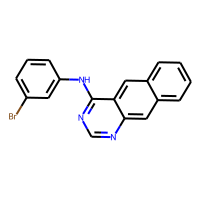
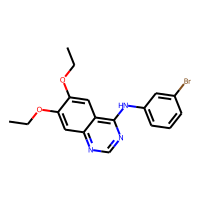
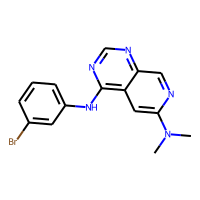

In [52]:
molecule_dataset.head(3)

In [55]:
def get_enrichment_data(molecules, similarity_measure, pic50_cutoff):
    """
    Calculates x and y values for enrichment plot:
        x - % ranked dataset
        y - % true actives identified

    Parameters
    ----------
    molecules : pandas.DataFrame
        Molecules with similarity values to a query molecule.
    similarity_measure : str
        Column name which will be used to sort the DataFrame．
    pic50_cutoff : float
        pIC50 cutoff value used to discriminate active and inactive molecules.

    Returns
    -------
    pandas.DataFrame
        Enrichment data: Percentage of ranked dataset by similarity vs. percentage of identified true actives.
    """

    # Get number of molecules in data set
    molecules_all = len(molecules)

    # Get number of active molecules in data set
    actives_all = sum(molecules["pIC50"] >= pic50_cutoff)

    # Initialize a list that will hold the counter for actives and molecules while iterating through our dataset
    actives_counter_list = []

    # Initialize counter for actives
    actives_counter = 0

    # Note: Data must be ranked for enrichment plots:
    # Sort molecules by selected similarity measure
    molecules.sort_values([similarity_measure], ascending=False, inplace=True)

    # Iterate over the ranked dataset and check each molecule if active (by checking bioactivity)
    for value in molecules["pIC50"]:
        if value >= pic50_cutoff:
            actives_counter += 1
        actives_counter_list.append(actives_counter)

    # Transform number of molecules into % ranked dataset
    molecules_percentage_list = [i / molecules_all for i in range(1, molecules_all + 1)]

    # Transform number of actives into % true actives identified
    actives_percentage_list = [i / actives_all for i in actives_counter_list]

    # Generate DataFrame with x and y values as well as label
    enrichment = pd.DataFrame(
        {
            "% ranked dataset": molecules_percentage_list,
            "% true actives identified": actives_percentage_list,
        }
    )

    return enrichment

In [56]:
pic50_cutoff = 6.3

In [57]:
similarity_measures = ["tanimoto_maccs", "tanimoto_morgan"]
enrichment_data = {
    similarity_measure: get_enrichment_data(molecule_dataset, similarity_measure, pic50_cutoff)
    for similarity_measure in similarity_measures
}

In [58]:
# NBVAL_CHECK_OUTPUT
enrichment_data["tanimoto_maccs"].head()

,% ranked dataset,% true actives identified
0,0.000221,0.000000
1,0.000442,0.000391
2,0.000663,0.000783
3,0.000884,0.001174
4,0.001105,0.001566


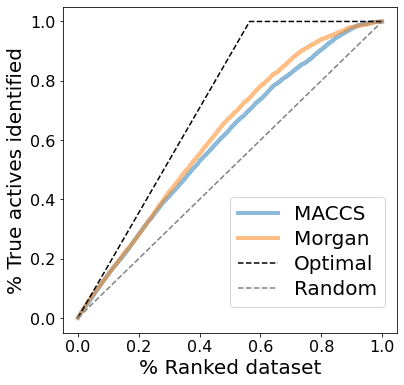

In [59]:
fig, ax = plt.subplots(figsize=(6, 6))

fontsize = 20

# Plot enrichment data
for similarity_measure, enrichment in enrichment_data.items():
    ax = enrichment.plot(
        ax=ax,
        x="% ranked dataset",
        y="% true actives identified",
        label=similarity_measure,
        alpha=0.5,
        linewidth=4,
    )
ax.set_ylabel("% True actives identified", size=fontsize)
ax.set_xlabel("% Ranked dataset", size=fontsize)

# Plot optimal curve: Ratio of actives in dataset
ratio_actives = sum(molecule_dataset["pIC50"] >= pic50_cutoff) / len(molecule_dataset)
ax.plot(
    [0, ratio_actives, 1],
    [0, 1, 1],
    label="Optimal curve",
    color="black",
    linestyle="--",
)

# Plot random curve
ax.plot([0, 1], [0, 1], label="Random curve", color="grey", linestyle="--")

plt.tick_params(labelsize=16)
plt.legend(
    labels=["MACCS", "Morgan", "Optimal", "Random"],
    loc=(0.5, 0.08),
    fontsize=fontsize,
    labelspacing=0.3,
)

# Save plot -- use bbox_inches to include text boxes
plt.savefig(
    DATA / "enrichment_plot.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

plt.show()

In [60]:
def calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff):
    """
    Get the experimental enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    enrichment : pd.DataFrame
        Enrichment data: Percentage of ranked dataset by similarity vs. percentage of
        identified true actives.
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.

    Returns
    -------
    float
        Experimental enrichment factor.
    """

    # Keep only molecules that meet the cutoff
    enrichment = enrichment[
        enrichment["% ranked dataset"] <= ranked_dataset_percentage_cutoff / 100
    ]
    # Get highest percentage of actives and the corresponding percentage of actives
    highest_enrichment = enrichment.iloc[-1]
    enrichment_factor = round(100 * float(highest_enrichment["% true actives identified"]), 1)
    return enrichment_factor

In [61]:
def calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff):
    """
    Get the random enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.

    Returns
    -------
    float
        Random enrichment factor.
    """

    enrichment_factor_random = round(float(ranked_dataset_percentage_cutoff), 1)
    return enrichment_factor_random

In [62]:
def calculate_enrichment_factor_optimal(molecules, ranked_dataset_percentage_cutoff, pic50_cutoff):
    """
    Get the optimal random enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    molecules : pandas.DataFrame
        the DataFrame with all the molecules and pIC50.
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.
    activity_cutoff: float
        pIC50 cutoff value used to discriminate active and inactive molecules

    Returns
    -------
    float
        Optimal enrichment factor.
    """

    ratio = sum(molecules["pIC50"] >= pic50_cutoff) / len(molecules) * 100
    if ranked_dataset_percentage_cutoff <= ratio:
        enrichment_factor_optimal = round(100 / ratio * ranked_dataset_percentage_cutoff, 1)
    else:
        enrichment_factor_optimal = 100.0
    return enrichment_factor_optimal

In [63]:
ranked_dataset_percentage_cutoff = 5

In [64]:
for similarity_measure, enrichment in enrichment_data.items():
    enrichment_factor = calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff)
    print(
        f"Experimental EF for {ranked_dataset_percentage_cutoff}% of ranked dataset ({similarity_measure}): {enrichment_factor}%"
    )
# NBVAL_CHECK_OUTPUT

Experimental EF for 5% of ranked dataset (tanimoto_maccs): 7.3%
Experimental EF for 5% of ranked dataset (tanimoto_morgan): 7.9%


In [65]:
enrichment_factor_random = calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff)
print(
    f"Random EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_random}%"
)
enrichment_factor_optimal = calculate_enrichment_factor_optimal(
    molecule_dataset, ranked_dataset_percentage_cutoff, pic50_cutoff
)
print(
    f"Optimal EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_optimal}%"
)
# NBVAL_CHECK_OUTPUT

Random EF for 5% of ranked dataset: 5.0%
Optimal EF for 5% of ranked dataset: 8.9%
